<a href="https://colab.research.google.com/github/luca-rn/Intelligent_Machines/blob/main/RCNNCardVision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/data-yolo.zip'

Mounted at /content/drive


In [3]:
import shutil
import os
import zipfile

# extract zip file
download_folder = "/content"
zip_name = "data-yolo.zip"
os.makedirs(download_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(download_folder)

print(f"Extraction complete! Files saved to {download_folder}")

Extraction complete! Files saved to /content


In [4]:
# split data into training and validation, still in yolo format

import os
import shutil
import random

# Paths
dataset_path = download_folder
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

# Output paths
train_img = os.path.join(dataset_path, "images/train")
val_img = os.path.join(dataset_path, "images/val")
train_lbl = os.path.join(dataset_path, "yolo/labels/train")
val_lbl = os.path.join(dataset_path, "yolo/labels/val")

# Create train/val folders
for d in [train_img, val_img, train_lbl, val_lbl]:
    os.makedirs(d, exist_ok=True)

# List images and shuffle
images = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])  # Adjust for other image formats
random.shuffle(images)

# Split 80% train, 20% val
split_idx = int(0.8 * len(images))
train_files, val_files = images[:split_idx], images[split_idx:]

# Move files
for file_list, img_dest, lbl_dest in [(train_files, train_img, train_lbl), (val_files, val_img, val_lbl)]:
    for file in file_list:
        shutil.move(os.path.join(image_dir, file), os.path.join(img_dest, file))
        label_file = file.replace(".jpg", ".txt")  # Assuming YOLO format
        if os.path.exists(os.path.join(label_dir, label_file)):
            shutil.move(os.path.join(label_dir, label_file), os.path.join(lbl_dest, label_file))

print("Dataset successfully split into training and validation sets!")

yolo_train_labels = train_lbl
yolo_val_labels = val_lbl

Dataset successfully split into training and validation sets!


In [5]:
# Converting from YOLO annotations to annotations for Faster RCNN

import os
import json
import glob
from PIL import Image

#classes = ["Exploding Kittens", "Munchkin", "Poker", "Uno"]

rcnn_train_labels = os.path.join(dataset_path, "labels/train")
rcnn_val_labels = os.path.join(dataset_path, "labels/val")

# Create directories if they don't exist
os.makedirs(rcnn_train_labels, exist_ok=True)
os.makedirs(rcnn_val_labels, exist_ok=True)

def yolo_to_rcnn_bbox(x_center, y_center, width, height, img_w, img_h):
    x_center *= img_w
    y_center *= img_h
    width *= img_w
    height *= img_h

    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2

    return [x_min, y_min, x_max, y_max]


def convert_yolo_folder_to_rcnn(yolo_folder,img_folder,out_folder):
  for label_file in os.listdir(yolo_folder):
    if not label_file.endswith('.txt'):
        continue

    img_name = label_file.replace('.txt', '.jpg')
    img_path = os.path.join(img_folder, img_name)
    label_path = os.path.join(yolo_folder, label_file)

    if not os.path.exists(img_path):
        print(f"Image not found for {label_file}, skipping.")
        continue

    img = Image.open(img_path)
    img_w, img_h = img.size

    with open(label_path, 'r') as f:
        lines = f.readlines()

    rcnn_lines = []
    for line in lines:
      class_id, x_c, y_c, w, h = map(float, line.strip().split())
      x_min, y_min, x_max, y_max = yolo_to_rcnn_bbox(x_c, y_c, w, h, img_w, img_h)
      rcnn_lines.append(f"{int(class_id)} {x_min} {y_min} {x_max} {y_max}")

    output_file = os.path.join(out_folder, label_file)
    with open(output_file, 'w') as f:
      f.write("\n".join(rcnn_lines))

    print(f'Converted labels from {yolo_folder} to {out_folder}')
  return out_folder

train_lbl = convert_yolo_folder_to_rcnn(yolo_train_labels, train_img, rcnn_train_labels)
val_lbl = convert_yolo_folder_to_rcnn(yolo_val_labels, val_img, rcnn_val_labels)

Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/labels/train to /content/labels/train
Converted labels from /content/yolo/la

In [6]:
# Read class names from classes.txt
classes_txt_path = os.path.join(dataset_path, "classes.txt")
with open(classes_txt_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
# Generate dataset.yaml
dataset_yaml_path = os.path.join(dataset_path, "dataset.yaml")
with open(dataset_yaml_path, "w") as f:
    f.write(f"train: {train_img}\n")
    f.write(f"val: {val_img}\n")
    f.write(f"nc: {len(class_names)}\n")
    f.write(f"names: {class_names}\n")

print('\nFile contents:\n')
!cat /content/dataset.yaml


File contents:

train: /content/images/train
val: /content/images/val
nc: 4
names: ['Exploding Kittens', 'Munchkin', 'Poker', 'Uno']


In [7]:
import yaml
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt

# 1️⃣ Parse your dataset.yaml
with open(dataset_yaml_path, 'r') as f:
    cfg = yaml.safe_load(f)
train_img_dir = cfg['train']
val_img_dir   = cfg['val']
num_classes   = cfg['nc'] + 1        # +1 for background class
class_names   = cfg['names']

train_lbl_dir = rcnn_train_labels
val_lbl_dir   = rcnn_val_labels

In [8]:
from torchvision.transforms import functional as F
import torchvision.transforms as T

def get_transforms(train):
    transforms = []
    # Converts PIL image to Tensor
    transforms.append(T.ToTensor())
    # You can add data augmentation here for training
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

class CardDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        # List of image filenames
        self.imgs = sorted([f for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))])

    def __getitem__(self, idx):
        img_filename = self.imgs[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        label_path = os.path.join(self.labels_dir, os.path.splitext(img_filename)[0] + '.txt')

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse annotation file
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                x_min, y_min, x_max, y_max = map(float, parts[1:])
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(cls)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
# Collate function needed for batching variable-size targets
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = CardDataset(train_img_dir, train_lbl_dir, transforms=get_transforms(True))
val_ds   = CardDataset(val_img_dir,   val_lbl_dir,   transforms=get_transforms(False))

from torchvision.ops import misc as misc_ops
DataLoader = torch.utils.data.DataLoader

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, collate_fn=collate_fn)

In [10]:
# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_f = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_f, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum = 0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s]


In [11]:
# Training and validation loops
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += loss_value

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1} Training -- Total Loss: {total_loss:.4f}, Average Loss: {avg_loss:.4f}")
    return total_loss, avg_loss


In [12]:
def validate(model, data_loader, device, epoch):
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            model.train()
            loss_dict = model(images, targets)
            model.eval()
            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()
    avg_val_loss = total_val_loss / len(data_loader)
    print(f"Epoch {epoch+1} Validation -- Total Loss: {total_val_loss:.4f}, Average Loss: {avg_val_loss:.4f}")
    return total_val_loss, avg_val_loss

In [14]:
# Run training
epochs = 60
training_stats = []
for epoch in range(epochs):
    train_total, train_avg = train_one_epoch(model, optim;o+izer, train_loader, device, epoch)
    val_total, val_avg = validate(model, val_loader, device, epoch)
    lr_scheduler.step()
    training_stats.append((train_total, train_avg, val_total, val_avg))

Epoch 1 Training -- Total Loss: 6.0824, Average Loss: 0.3578
Epoch 1 Validation -- Total Loss: 5.3954, Average Loss: 0.5995
Epoch 2 Training -- Total Loss: 4.5955, Average Loss: 0.2703
Epoch 2 Validation -- Total Loss: 4.6789, Average Loss: 0.5199
Epoch 3 Training -- Total Loss: 4.3407, Average Loss: 0.2553
Epoch 3 Validation -- Total Loss: 4.4013, Average Loss: 0.4890
Epoch 4 Training -- Total Loss: 4.7785, Average Loss: 0.2811
Epoch 4 Validation -- Total Loss: 4.2235, Average Loss: 0.4693
Epoch 5 Training -- Total Loss: 3.5340, Average Loss: 0.2079
Epoch 5 Validation -- Total Loss: 4.1767, Average Loss: 0.4641
Epoch 6 Training -- Total Loss: 3.8850, Average Loss: 0.2285
Epoch 6 Validation -- Total Loss: 4.2049, Average Loss: 0.4672
Epoch 7 Training -- Total Loss: 3.4762, Average Loss: 0.2045
Epoch 7 Validation -- Total Loss: 4.2162, Average Loss: 0.4685
Epoch 8 Training -- Total Loss: 3.4282, Average Loss: 0.2017
Epoch 8 Validation -- Total Loss: 4.2447, Average Loss: 0.4716
Epoch 9 

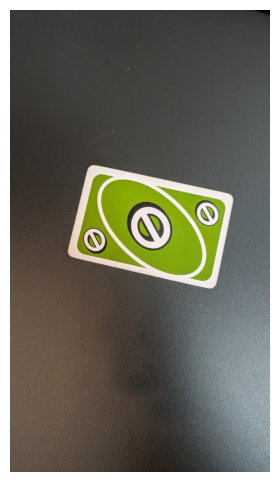

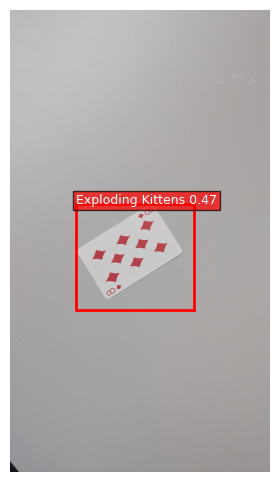

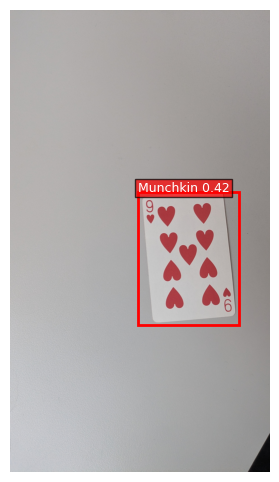

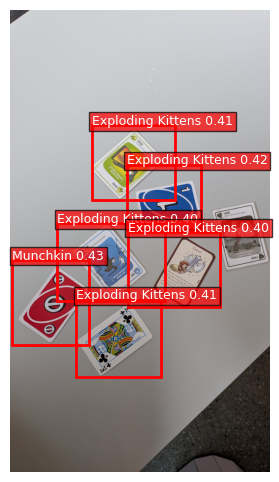

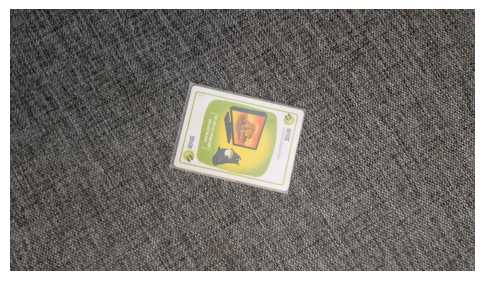

In [15]:
CLASS_MAP = {2: "Exploding Kittens", 3: "Munchkin", 4: "Poker", 5: "Uno"}

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(dataset, model, device, num_images=5, score_threshold=0.3):
    model.eval()
    for idx in range(min(num_images, len(dataset))):
        img, _ = dataset[idx]
        orig = img.mul(255).permute(1, 2, 0).byte().numpy()

        fig, ax = plt.subplots(1, figsize=(6,6))
        ax.imshow(orig)

        with torch.no_grad():
            pred = model([img.to(device)])[0]

        # loop over boxes, labels, and scores
        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            if score.item() < score_threshold:
                continue

            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # draw class name and score
            text = f"{CLASS_MAP[int(label.item())]} {score.item():.2f}"
            ax.text(
                x1, y1 - 4, text,
                fontsize=9, color='white',
                bbox=dict(facecolor='red', alpha=0.7, pad=2)
            )

        plt.axis('off')
        plt.show()

# Example usage:
visualize_predictions(val_ds, model, device, num_images=5, score_threshold=0.4)